# SciPy based transforms

In the last notebook `getting_started_with_robot_ik.ipynb` we have familiarized ourselves with the concept of Forward and Inverse Kinematics (IK) and implemented a simple IK solver for a 3DOF leg using trigonometry. In this notebook we will use SciPy to implement a more advanced IK solver.

SciPy, a Python library built upon NumPy, provides a wide array of mathematical algorithms and functions that are valuable for robotics, including linear algebra, which is of interest here.

The first step is to convert our forward kinematics code from custom Points and hand crafted function to use matrix transforms for rotation and translation.

Alongside the conversion, we are going to bring all the algorithms to work in full 3D space, not just 2D projections.

In [31]:
# Enable python modules live reloading
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [32]:
import numpy as np
from scipy.spatial.transform import Rotation as R
from point import Point3D, Line3D, Leg3D

def forward_kinematics(
    coxa_length, femur_length, tibia_length, alpha, beta, gamma, start_height=2, body_length=5
):
    # Define initial points in local coordinates
    start_point = Point3D([0, start_height, 0])
    body_local = Point3D([body_length, 0, 0])
    coxa_local = Point3D([coxa_length, 0, 0])
    femur_local = Point3D([femur_length, 0, 0])
    tibia_local = Point3D([tibia_length, 0, 0])

    # Create rotation matrices
    rotation_axis = np.array([0, 0, 1])
    r_alpha = R.from_rotvec(rotation_axis * alpha, degrees=True)
    r_beta = R.from_rotvec(rotation_axis * beta, degrees=True)
    r_gamma = R.from_rotvec(rotation_axis * gamma, degrees=True)

    # Calculate global positions using transformations
    body_point = start_point + body_local

    # Apply alpha rotation to coxa
    coxa_rotated = r_alpha.apply(coxa_local.numpy())
    coxa_point = body_point + coxa_rotated

    # Apply alpha+beta rotation to femur
    r_alpha_beta = r_alpha * r_beta
    femur_rotated = r_alpha_beta.apply(femur_local.numpy())
    femur_point = coxa_point + femur_rotated

    # Apply alpha+beta+gamma rotation to tibia
    r_alpha_beta_gamma = r_alpha_beta * r_gamma
    tibia_rotated = r_alpha_beta_gamma.apply(tibia_local.numpy())
    tibia_point = femur_point + tibia_rotated

    # Set  Point labels for visualization
    body_point.label = rf'$\alpha$={alpha}°'
    coxa_point.label = rf'$\beta$={beta}°'
    femur_point.label = rf'$\gamma$={gamma}°'
    tibia_point.label = 'Foot'

    # Return lines connecting the points
    return Leg3D([
        Line3D(start_point, body_point, 'Body'),
        Line3D(body_point, coxa_point, 'Coxa'),
        Line3D(coxa_point, femur_point, 'Femur'),
        Line3D(femur_point, tibia_point, 'Tibia'),
    ])


ValueError: 'bboxes' cannot be empty

<Figure size 640x480 with 4 Axes>

ValueError: 'bboxes' cannot be empty

<Figure size 640x480 with 1 Axes>

ValueError: 'bboxes' cannot be empty

<Figure size 640x480 with 1 Axes>

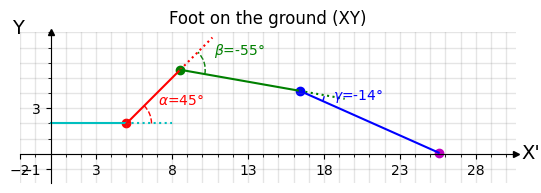

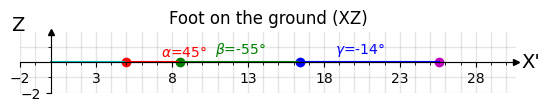

In [33]:
%matplotlib inline

from plotting import plot_leg_with_points

coxa = 5
femur = 8
tibia = 10


model = forward_kinematics(coxa, femur, tibia, 45, -55, -14)

_ = plot_leg_with_points(model.xy, 'Foot on the ground (XY)', link_labels='none', x_label="X'", y_label='Y')
_ = plot_leg_with_points(model.xz, 'Foot on the ground (XZ)', link_labels='none', x_label="X'", y_label='Z')

This was a good start, but code is hard to read and understand due to excessive repetitions. Let's introduce a transform system, similar to the one used in ROS TF2 library.

With this `Transform` class we can now create a chain of transformations instead of hand crafting them.

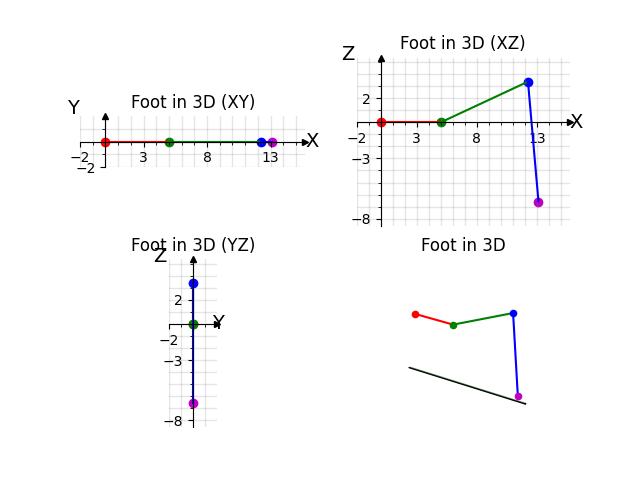

In [34]:
from transforms import Transform
from plotting import plot_leg3d

def forward_kinematics_transforms(
    coxa_length,
    femur_length,
    tibia_length,
    alpha,
    beta,
    gamma,
    leg_location_on_body=[0, 0, 0],
    leg_rotation=[0, 0, 0],
    body_transform=Transform.identity(),
    verbose=False,
):
    # Create rotation matrices and transforms
    body_link = body_transform @ Transform.from_translation(leg_location_on_body)
    body_joint = body_link @ Transform.from_rotvec(leg_rotation, degrees=True)

    coxa_joint = body_joint @ Transform.from_rotvec([0, 0, alpha], degrees=True)
    coxa_link = coxa_joint @ Transform.from_translation([coxa_length, 0, 0])

    femur_joint = coxa_link @ Transform.from_rotvec([0, beta, 0], degrees=True)
    femur_link = femur_joint @ Transform.from_translation([femur_length, 0, 0])

    tibia_joint = femur_link @ Transform.from_rotvec([0, gamma, 0], degrees=True)
    tibia_link = tibia_joint @ Transform.from_translation([tibia_length, 0, 0])

    # Calculate global positions using transformations
    identity_point = Point3D([0, 0, 0])

    body_start = body_transform.apply_point(identity_point)

    body_end = body_link.apply_point(identity_point)
    body_end.label = rf'$\alpha$={alpha}°'

    coxa_end = coxa_link.apply_point(identity_point)
    coxa_end.label = rf'$\beta$={beta}°'

    femur_end = femur_link.apply_point(identity_point)
    femur_end.label = rf'$\gamma$={gamma}°'

    tibia_end = tibia_link.apply_point(identity_point)
    tibia_end.label = 'Foot'

    result = Leg3D(
        [
            Line3D(body_start, body_end, 'Body'),
            Line3D(body_end, coxa_end, 'Coxa'),
            Line3D(coxa_end, femur_end, 'Femur'),
            Line3D(femur_end, tibia_end, 'Tibia'),
        ]
    )

    if verbose:
        print(f'{body_end=}')
        print(f'{coxa_end=}')
        print(f'{femur_end=}')
        print(f'{tibia_end=}')
        for line in result:
            print(line)

    return result


coxa = 5
femur = 8
tibia = 10

model = forward_kinematics_transforms(coxa, femur, tibia, 0, -25, 110)


%matplotlib widget
# %matplotlib inline

fig, _, _, _ = plot_leg_with_points(model.xy, 'Foot in 3D (XY)', link_labels='none', joint_labels='points', x_label='X', y_label='Y', subplot=221)
_ = plot_leg_with_points(model.xz, 'Foot in 3D (XZ)', link_labels='none', joint_labels='points', x_label='X', y_label='Z', subplot=222, fig=fig)
_ = plot_leg_with_points(model.yz, 'Foot in 3D (YZ)', link_labels='none', joint_labels='points', x_label='Y', y_label='Z', subplot=223, fig=fig)
_ = plot_leg3d(model, 'Foot in 3D', link_labels='none', joint_labels='points', subplot=224, fig=fig)

# print("foot position: ", model.lines[-1].end)

With full 3D kinematics model and plotting support lets setup a 6 legged robot.

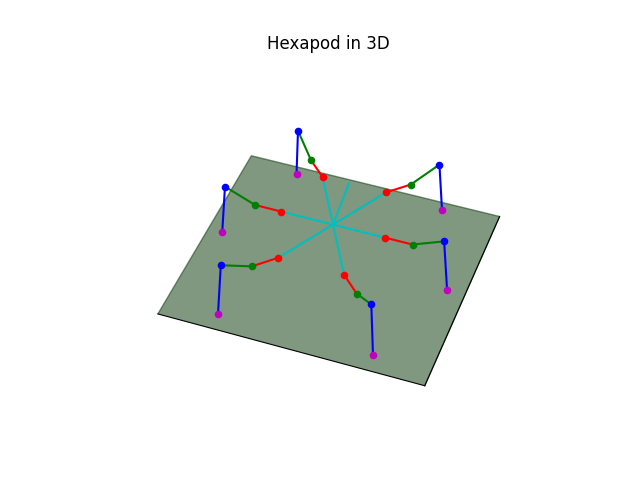

In [35]:
# Dr.QP Dimensions
from models import LegModel
from plotting import plot_update_leg3d_lines


drqp_front_offset = 0.116924  # x offset for the front and back legs
drqp_side_offset = 0.063871  # y offset fo the front and back legs
drqp_middle_offset = 0.103  # x offset for the middle legs

drqp_coxa = 0.053
drqp_femur = 0.066225
drqp_tibia = 0.123


class DrQP:
    def __init__(self, coxa_len=drqp_coxa, femur_len=drqp_femur, tibia_len=drqp_tibia):
        self.left_front_leg = LegModel(
            coxa_len,
            femur_len,
            tibia_len,
            label='left_front',
            rotation=[0, 0, 45],
            location_on_body=[drqp_front_offset, drqp_side_offset, 0.0],
        )
        self.left_middle_leg = LegModel(
            coxa_len,
            femur_len,
            tibia_len,
            label='left_middle',
            rotation=[0, 0, 90],
            location_on_body=[0.0, drqp_middle_offset, 0.0],
        )
        self.left_back_leg = LegModel(
            coxa_len,
            femur_len,
            tibia_len,
            label='left_back',
            rotation=[0, 0, 135],
            location_on_body=[-drqp_front_offset, drqp_side_offset, 0.0],
        )

        self.right_front_leg = LegModel(
            coxa_len,
            femur_len,
            tibia_len,
            label='right_front',
            rotation=[0, 0, -45],
            location_on_body=[drqp_front_offset, -drqp_side_offset, 0.0],
        )
        self.right_middle_leg = LegModel(
            coxa_len,
            femur_len,
            tibia_len,
            label='right_middle',
            rotation=[0, 0, -90],
            location_on_body=[0.0, -drqp_middle_offset, 0.0],
        )
        self.right_back_leg = LegModel(
            coxa_len,
            femur_len,
            tibia_len,
            label='right_back',
            rotation=[0, 0, -135],
            location_on_body=[-drqp_front_offset, -drqp_side_offset, 0.0],
        )
        self.update_head()

    def forward_kinematics(self, alpha, beta, gamma):
        for leg in self.legs:
            leg.forward_kinematics(alpha, beta, gamma)

    @property
    def legs(self):
        return [
            self.left_front_leg,
            self.left_middle_leg,
            self.left_back_leg,
            self.right_front_leg,
            self.right_middle_leg,
            self.right_back_leg,
        ]

    @property
    def body_transform(self):
        return self.left_front_leg.body_transform

    @body_transform.setter
    def body_transform(self, value):
        for leg in self.legs:
            leg.body_transform = value

        self.update_head()

    def update_head(self):
        # Head, x-forward
        self.head = Line3D(
            drqp.body_transform.apply_point(Point3D([0, 0, 0])),
            drqp.body_transform.apply_point(Point3D([drqp_front_offset, 0, 0])),
            'Head',
        )


def plot_drqp(drqp, targets=None):
    fig, ax = None, None

    class PlotData:
        def __init__(self):
            self.leg_lines = []
            self.leg_joints = []
            self.head_line = None

    plot_data = PlotData()

    for leg in drqp.legs:
        fig, ax, lines, joints = plot_leg3d(
            leg,
            'Hexapod in 3D',
            link_labels='none',
            joint_labels='points',
            subplot=111,
            fig=fig,
            ax=ax,
        )
        plot_data.leg_lines.append(lines)
        plot_data.leg_joints.append(joints)

    plot_data.head_line = ax.plot(*zip(drqp.head.start, drqp.head.end), 'c')[0]

    if targets:
        ax.scatter(
            *zip(*[target.numpy() for target in targets]), color='k', label='unreachable target'
        )

    ax.view_init(elev=44.0, azim=-160)
    return fig, ax, plot_data


def update_drqp_plot(drqp, plot_data):
    for leg, lines, joints in zip(drqp.legs, plot_data.leg_lines, plot_data.leg_joints):
        plot_update_leg3d_lines(leg, lines, joints)

    if plot_data.head_line:
        plot_data.head_line.set_data_3d(*zip(drqp.head.start, drqp.head.end))


drqp = DrQP()
drqp.forward_kinematics(0, -25, 110)
_ = plot_drqp(drqp)


With the ability to do forward kinematics for a full robot, we can now start to work on the inverse kinematics. getting_started_with_robot_ik.ipynb notebook covers the full 3D case of a single leg IK, however it works in the leg's local coordinate frame. In order to use it for the full robot, each leg global target position needs to be converted to the leg's local coordinate frame. Since we used matrix transformations for the forward kinematics, we can use the inverse of the body transform to convert the global target to the local coordinate frame.

```python
    def to_local(self, point):
        return self.body_joint.inverse().apply_point(point)
```

Leg left_middle failed to reach Point3D(-0.0800, 0.3174, -0.0945, Unreachable target), ended at Point3D(-0.0768, 0.3088, -0.0896, Foot)
Leg left_back failed to reach Point3D(-0.2844, 0.2119, -0.0945, Unreachable target), ended at Point3D(-0.2806, 0.2086, -0.0917, Foot)
Leg right_middle failed to reach Point3D(-0.0800, -0.3174, -0.0945, Unreachable target), ended at Point3D(-0.0768, -0.3088, -0.0896, Foot)
Leg right_back failed to reach Point3D(-0.2844, -0.2119, -0.0945, Unreachable target), ended at Point3D(-0.2806, -0.2086, -0.0917, Foot)


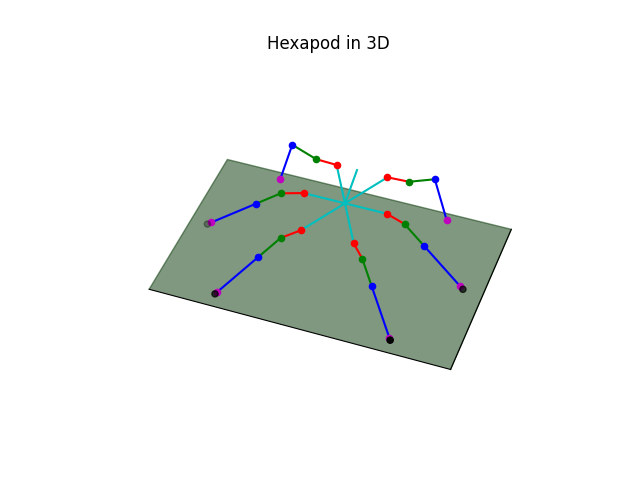

In [36]:
orig_alpha, orig_beta, orig_gamma = 0, -25, 110
drqp = DrQP()
drqp.forward_kinematics(orig_alpha, orig_beta, orig_gamma)

targets = []
for leg in drqp.legs:
    target = leg.tibia_end.copy()
    target.label = 'Target'
    target.x -= 0.08
    target.y *= 1.4

    reached = leg.move_to(target)
    if not reached:
        target.label = 'Unreachable target'
        targets.append(target)
        print(f'Leg {leg.label} failed to reach {target}, ended at {leg.tibia_end}')

_ = plot_drqp(drqp, targets)

With the ability to position all legs, its time to work on the inverse kinematics for the body. 

The algorithm is as follows:
 1. Capture the reference stance
    - Run forward kinematics for all legs with the same angles in a desired position (neutral, wide, narrow, specific gait). 
    - Capture global positions of all leg foot tips
 2. Apply transform to the robot's body (translation, rotation, twist).
 3. Run inverse kinematics for all legs with the foot positions captured in step 1.

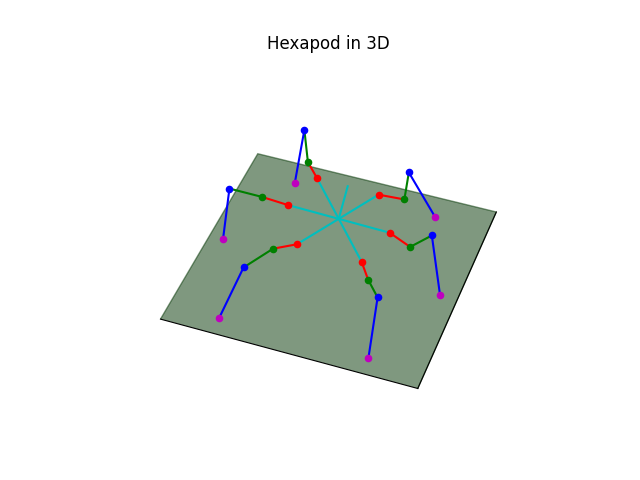

In [37]:
orig_alpha, orig_beta, orig_gamma = 0, -25, 110
drqp = DrQP()
drqp.forward_kinematics(orig_alpha, orig_beta, orig_gamma)

targets = [leg.tibia_end.copy() for leg in drqp.legs]

drqp.body_transform = Transform.from_translation([0.05, 0, -0.01]) @ Transform.from_rotvec([10, 10, 10], degrees=True)

unreachable_targets = []
for leg, target in zip(drqp.legs, targets):
    reached = leg.move_to(target)
    if not reached:
        target.label = 'Unreachable target'
        unreachable_targets.append(target)
        print(f'Leg {leg.label} failed to reach {target}, ended at {leg.tibia_end}')

_ = plot_drqp(drqp, unreachable_targets)

In [38]:
# Plot IK solutions and targets into an animation

import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

plt.rcParams["animation.html"] = "jshtml"
plt.ioff()

orig_alpha, orig_beta, orig_gamma = 0, -25, 110
drqp = DrQP()
drqp.forward_kinematics(orig_alpha, orig_beta, orig_gamma)

targets = [leg.tibia_end.copy() for leg in drqp.legs]

transforms = []

for i in range(0, 20):
    transforms.append(Transform.from_rotvec([0, 0, i], degrees=True))

for i in range(20, -20, -1):
    transforms.append(Transform.from_rotvec([0, 0, i], degrees=True))

for i in range(-20, 0):
    transforms.append(Transform.from_rotvec([0, 0, i], degrees=True))

fig, ax, plot_data = plot_drqp(drqp)

def animate(frame):
    drqp.body_transform = transforms[frame]
    for leg, target in zip(drqp.legs, targets):
        leg.move_to(target)
    update_drqp_plot(drqp, plot_data)

FuncAnimation(fig, animate, frames=len(transforms), interval=50)